In [18]:
import numpy as np
import os, glob, yaml, json, lz4.frame
from tutorials.utils import plotting
from tutorials.utils import plot_new
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [19]:
def compare_prod_equal(coins_dicts):
    exps = coins_dicts[0].keys()
    num_env = len(coins_dicts)
    print(f"{num_env} envs in total")

    planner_util = {exp_name:0 for exp_name in exps}
    productivity = {exp_name:0 for exp_name in exps}

    for env_idx in range(num_env):
        coins_dict = coins_dicts[env_idx]
        for idx, exp_name in enumerate(exps):
            exp_log = coins_dict[exp_name]
            accum_reward = 0
            p_reward = []
            for x in exp_log["rewards"]:
                accum_reward += x['p']
                p_reward.append(accum_reward)

                agent_coin = {}
                for i in range(3):
                    agent_coin[i] = [x[str(i)]["inventory"]['Coin'] + x[str(i)]["escrow"]['Coin'] for x in exp_log["states"]]

            prod = np.array([agent_coin[i][-1] for i in range(3)]).sum()

            planner_util[exp_name] += p_reward[-1] / num_env
            productivity[exp_name] += prod / num_env

    return planner_util, productivity


In [34]:
def compare_tax_policy(dense_log_dicts):
    exps = dense_log_dicts[0].keys()
    num_env = len(dense_log_dicts)
    print(f"{num_env} envs in total")

    cutoff_list = []
    cutoff_flag = False
    rate_exp = {}

    for env_idx in range(num_env):
        dense_log_dict = dense_log_dicts[env_idx]
        
        for idx, exp_name in enumerate(exps):
            exp_log = dense_log_dict[exp_name]

            rate_list = []
            for x in exp_log['PeriodicTax']:
                if isinstance(x, dict):

                    if not cutoff_flag:
                        for tax_cutoff_val in x['cutoffs']:
                            cutoff_list.append(int(tax_cutoff_val))
                        num_bracket = len(cutoff_list)
                        cutoff_flag = True

                    for tax_rate in x['schedule']:
                        rate_list.append(tax_rate + (idx-2) * 0.002)
            
            rate_arr = np.array(rate_list).reshape(-1, num_bracket)

            if exp_name not in rate_exp.keys():
                rate_exp[exp_name] = rate_arr / num_env
            else:
                rate_exp[exp_name] += rate_arr / num_env
    
    return cutoff_list, rate_exp

In [21]:
def load_episode_log(filepath):
    with lz4.frame.open(filepath, mode="rb") as log_file:
        log_bytes = log_file.read()
    return json.loads(log_bytes)

# def get_latest_log(root):
#     log_folders = [item for item in os.listdir(root) if item.startswith('logs_')]
#     if not log_folders:
#         return None  
#     log_folders.sort()
#     return log_folders[-1]

log_dir = f"/home/zilong/Downloads/dense_logs"
exps_dir = sorted(glob.glob(f"{log_dir}/*"))

num_env = 100
exp_names = []
dense_log_dicts = [{}] * num_env

for exp_path in exps_dir:
    exp_name = os.path.basename(exp_path)
    exp_names.append(exp_name)

    dense_log_exp_envs = sorted(glob.glob(f"{exp_path}/*"))
    for idx_env, env_path in enumerate(dense_log_exp_envs):
        log_exp_env = load_episode_log(env_path)
        dense_log_dicts[idx_env][exp_name] = log_exp_env


In [22]:
planner_util, productivity = compare_prod_equal(dense_log_dicts)

100 envs in total


In [35]:
cutoff_list, rate_exp = compare_tax_policy(dense_log_dicts)
cutoffs_ext = cutoff_list + [cutoff_list[-1] + 50]

100 envs in total


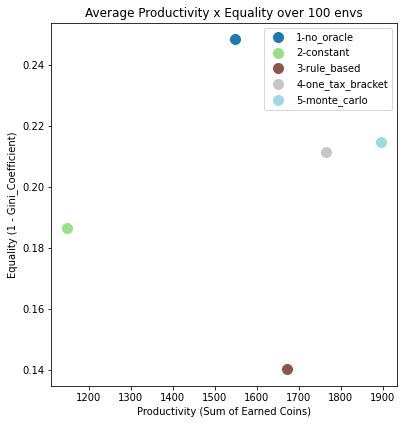

In [39]:
# vis average prod x equality
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=False)
plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.08)
cmap_tax = plt.get_cmap("tab20", len(exp_names))

for idx, exp_name in enumerate(exp_names):
    prod = productivity[exp_name]
    p_util = planner_util[exp_name]
    equal = p_util / prod
    # print(f"[{exp_name}] Prod {prod}, Equal {equal}")

    # circle = patches.Circle((prod, equal), 0.2, facecolor=cmap_tax(idx), lw=2, label=f"{exp_name}")
    # ax.add_patch(circle)
    ax.scatter(prod, equal, s=100, color=cmap_tax(idx), label=f"{exp_name}")
    ax.set_xlabel(f"Productivity (Sum of Earned Coins)")
    ax.set_ylabel("Equality (1 - Gini_Coefficient)")
    ax.set_title("Average Productivity x Equality over 100 envs")
    ax.legend()
plt.savefig(f"./plots/compare_prod_equal.png")

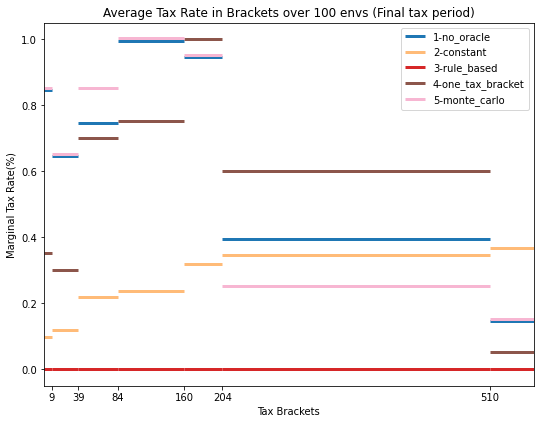

In [44]:
# tab20
fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=False)
plt.subplots_adjust(left=0.1, right=0.95, top=0.92, bottom=0.08)
cmap_tax = plt.get_cmap("tab20", len(exp_names)+2)

# for period in range(period_cnt):
#     ax = axes[period]
#     ax.vlines(cutoff_list, -0.95, 1.0, colors='b', linestyles='dashed', lw=1)

for idx, exp_name in enumerate(exp_names):
        rate_list = rate_exp[exp_name][-1, :]
        ax.hlines(rate_list, cutoff_list, cutoffs_ext[1:], lw=3, 
        colors=cmap_tax(idx), label=f"{exp_name}")

ax.set_xticks(cutoff_list[1:])
ax.set_xlim([cutoffs_ext[0], cutoffs_ext[-1]])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel(f"Tax Brackets")
ax.set_ylabel("Marginal Tax Rate(%)")
ax.set_title(f"Average Tax Rate in Brackets over 100 envs (Final tax period)")
ax.legend()

plt.savefig(f"./plots/compare_tax.png")

Visualizing Exp [1-no_oracle]
Visualizing Exp [2-constant]
Visualizing Exp [3-rule_based]
Visualizing Exp [4-one_tax_bracket]
Visualizing Exp [5-monte_carlo]


/home/zilong/Disk_sda6/AI_Econ/tutorials/utils/plot_new.py:527: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig4, axes = plt.subplots(1, 1, figsize=(10, 6), sharey=False)


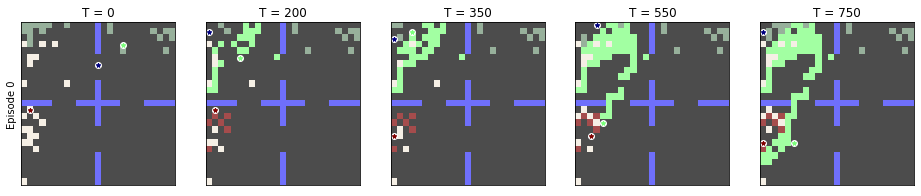

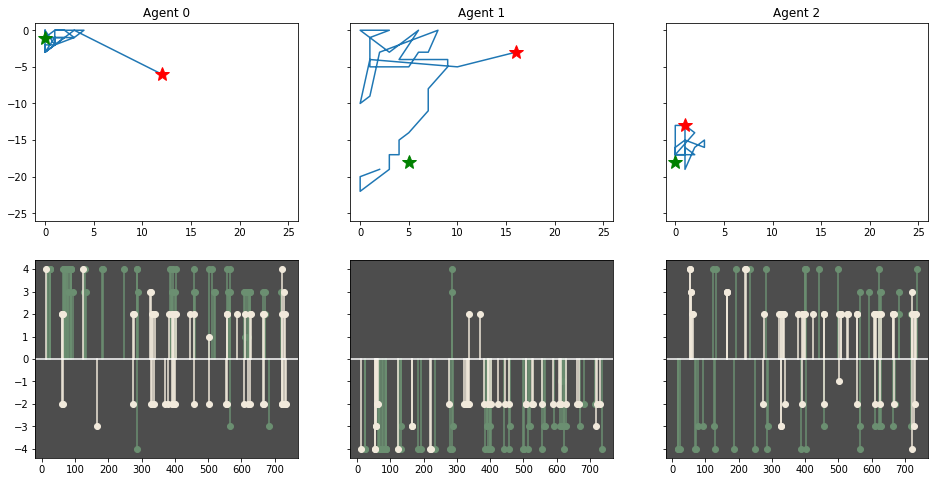

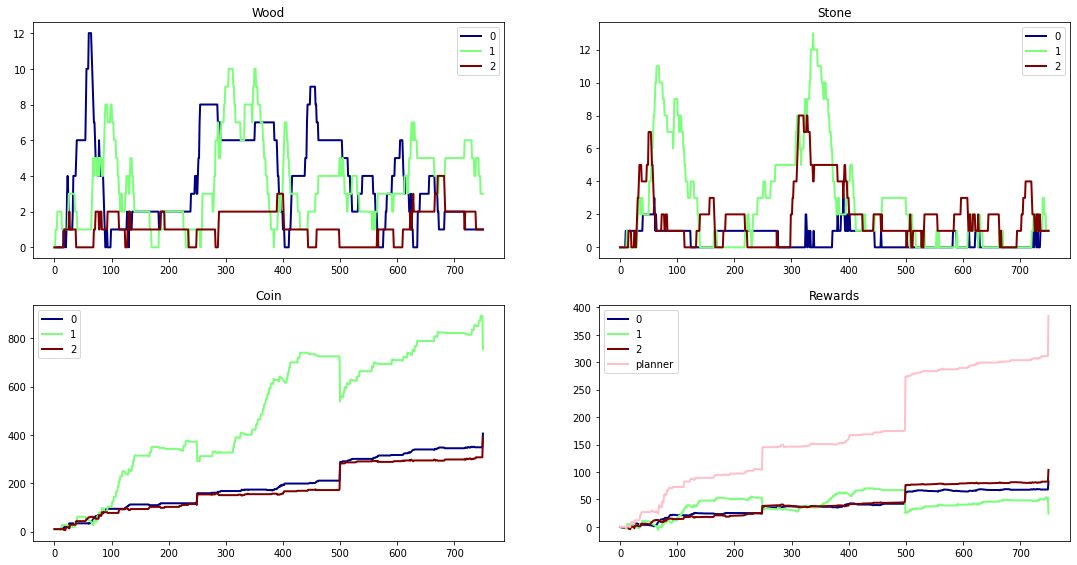

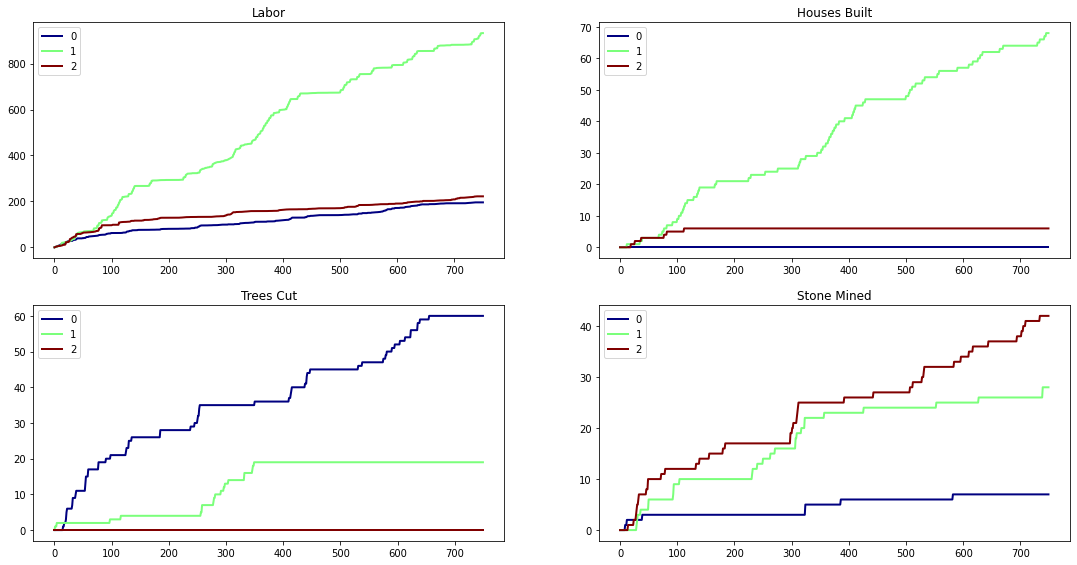

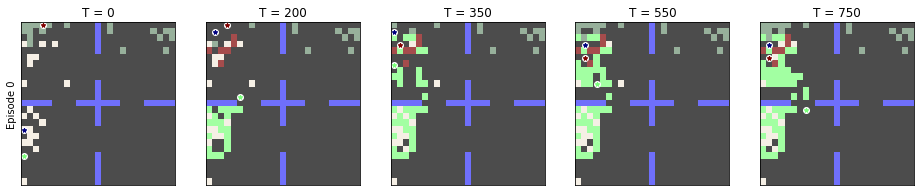

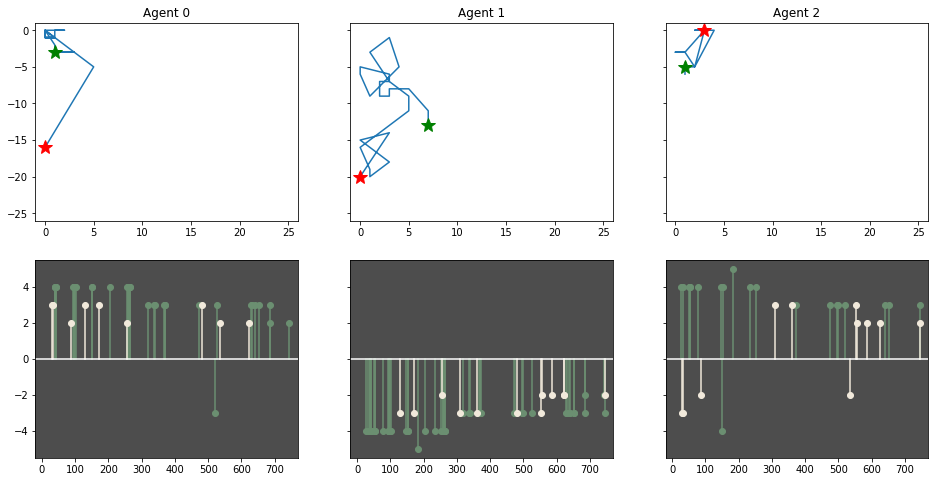

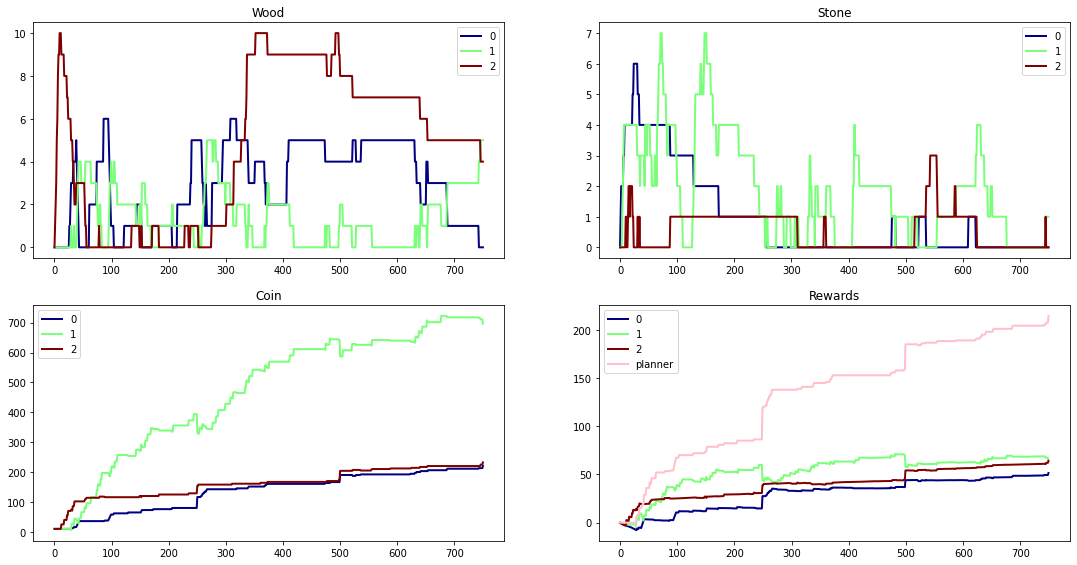

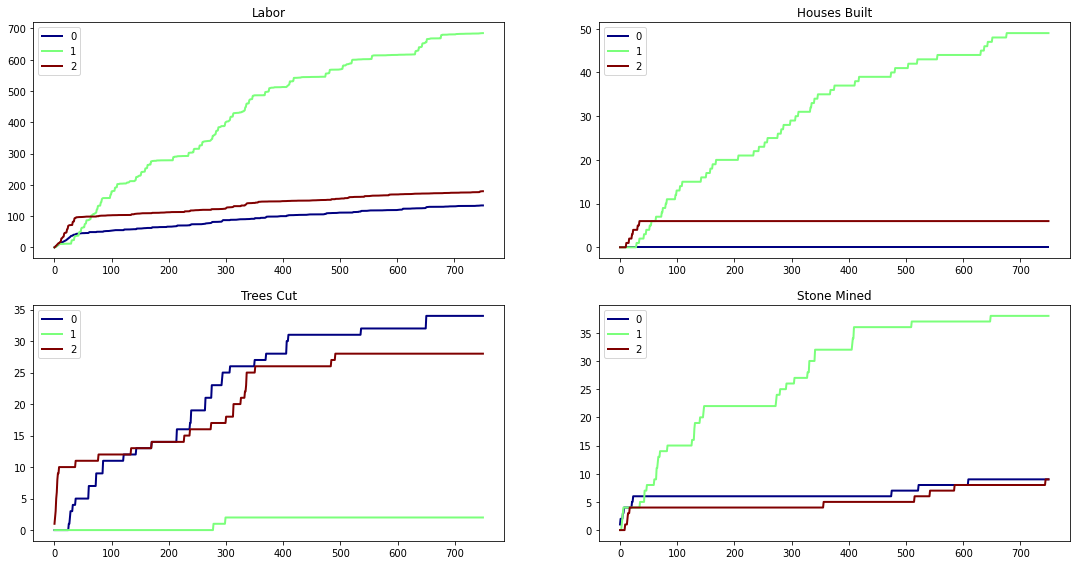

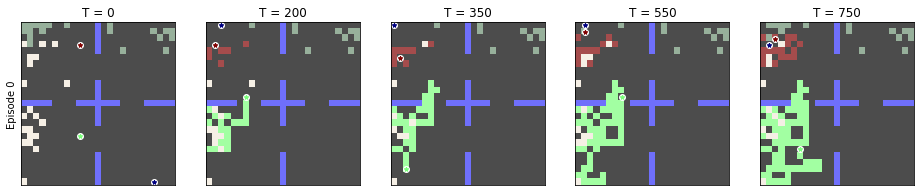

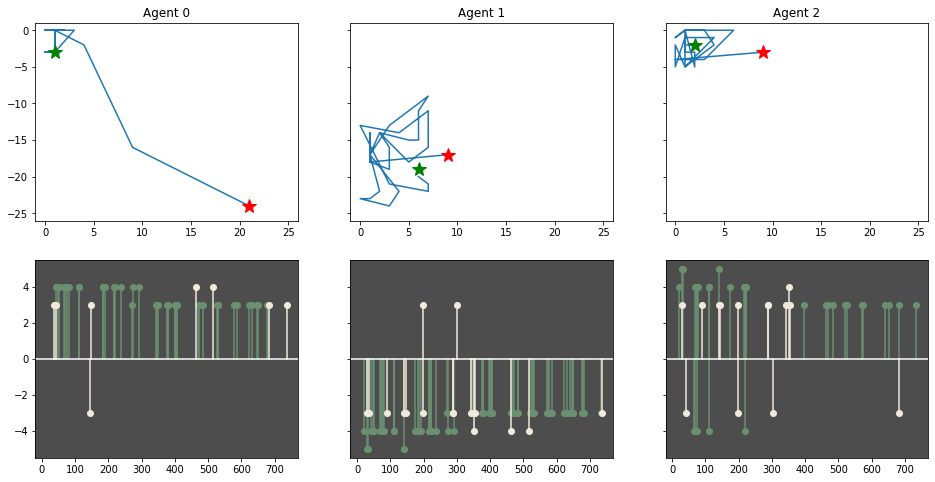

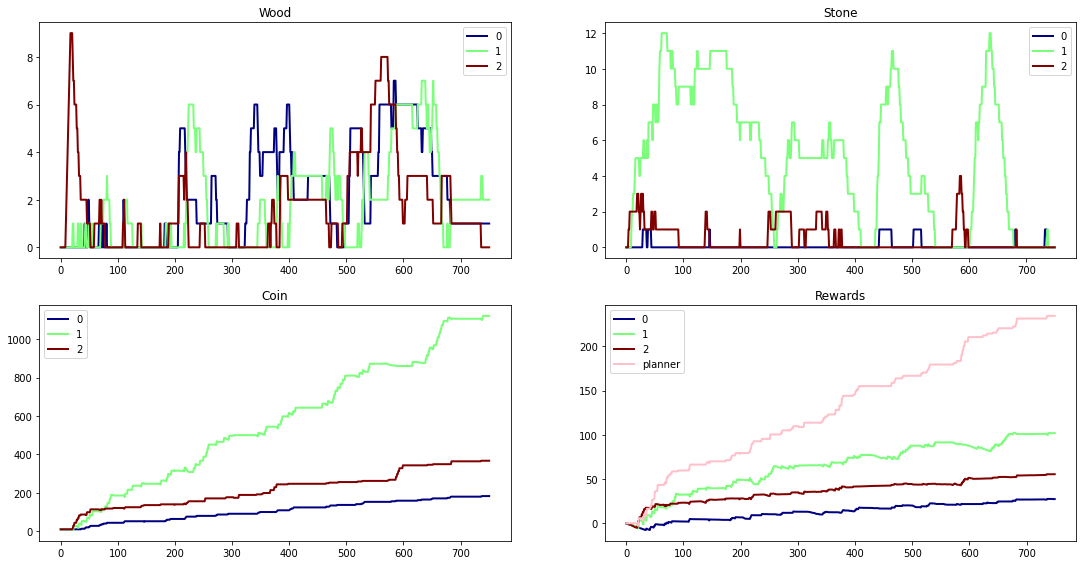

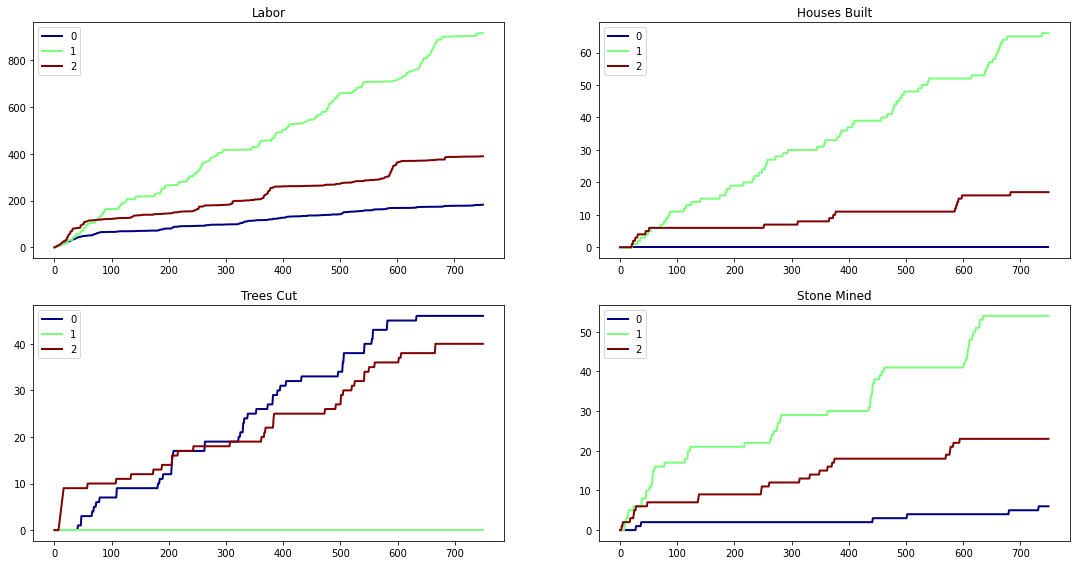

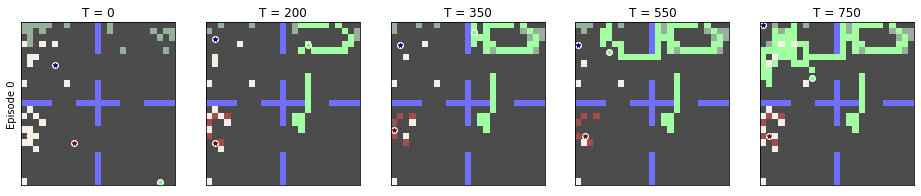

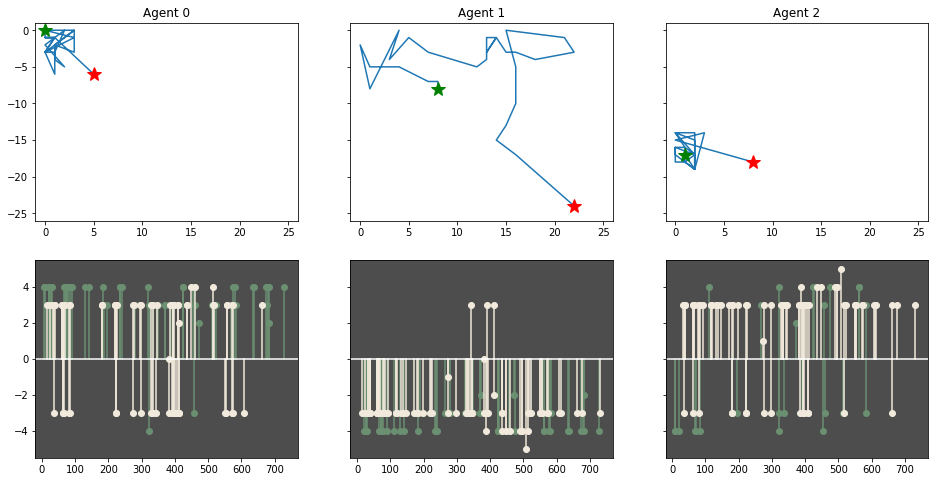

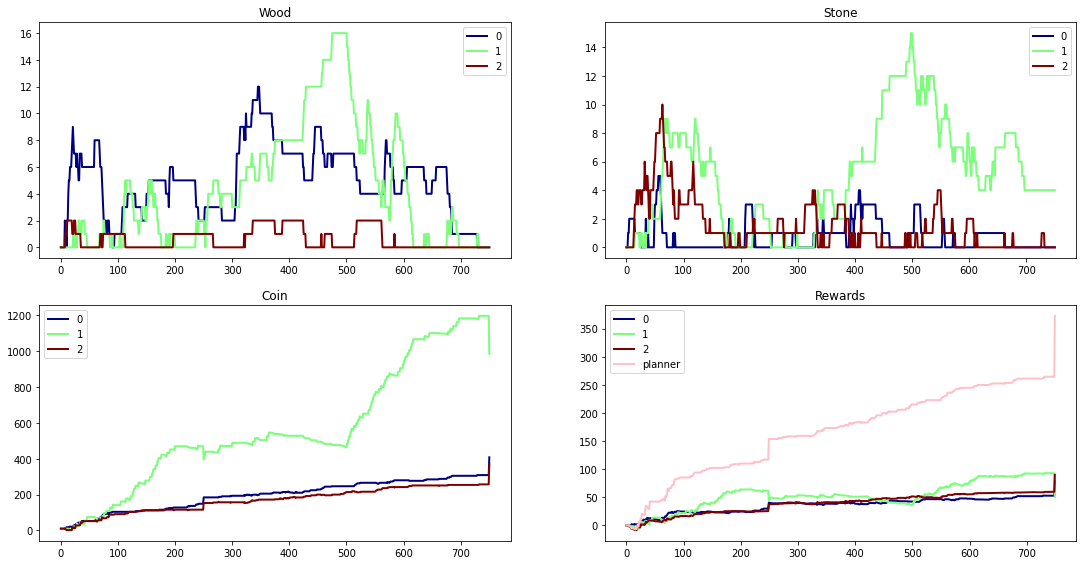

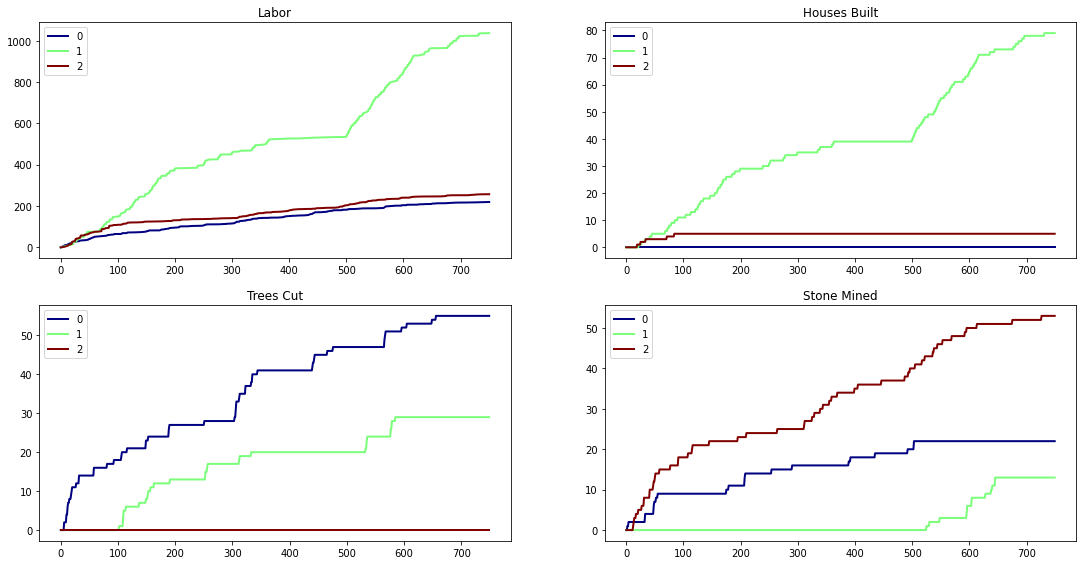

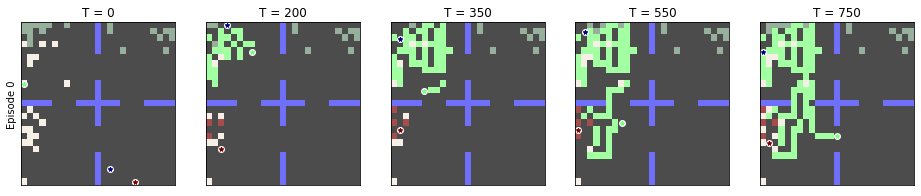

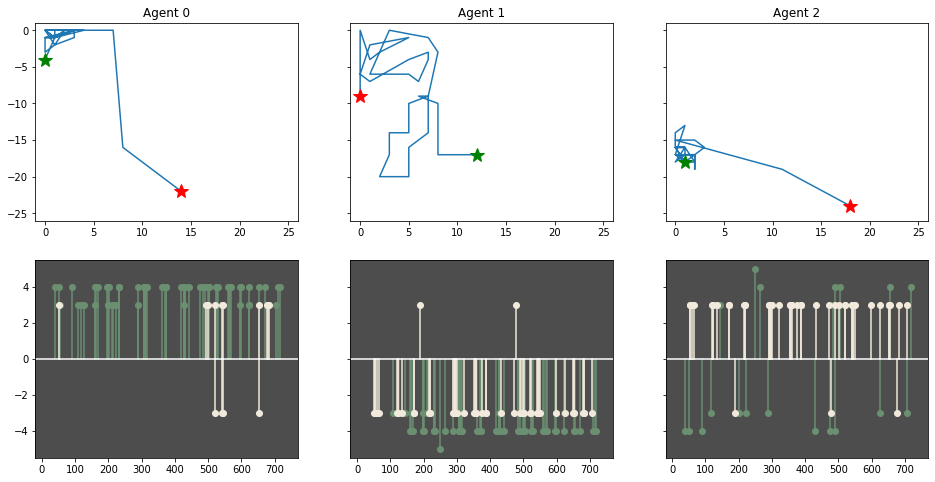

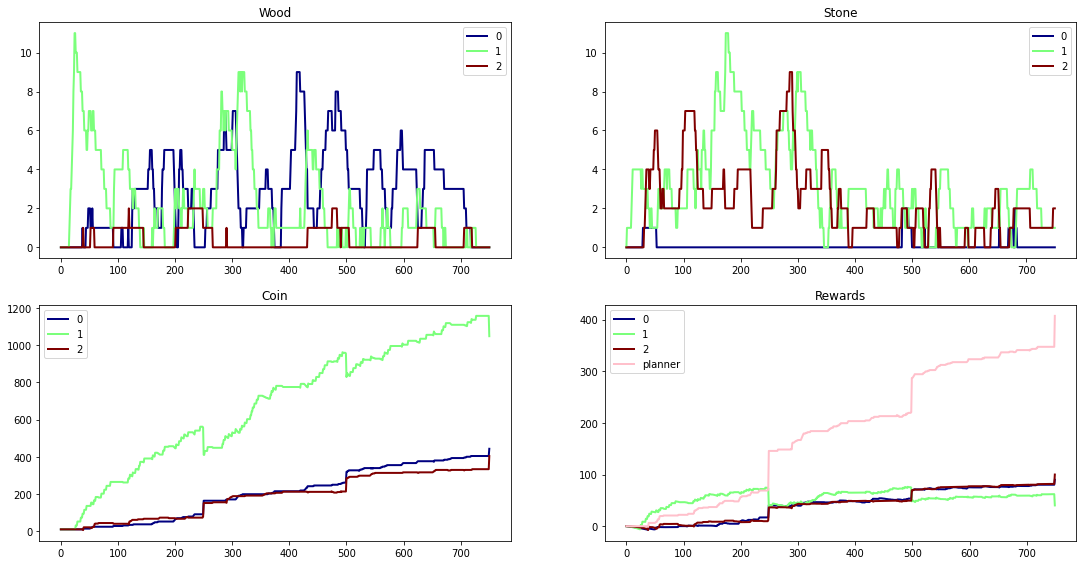

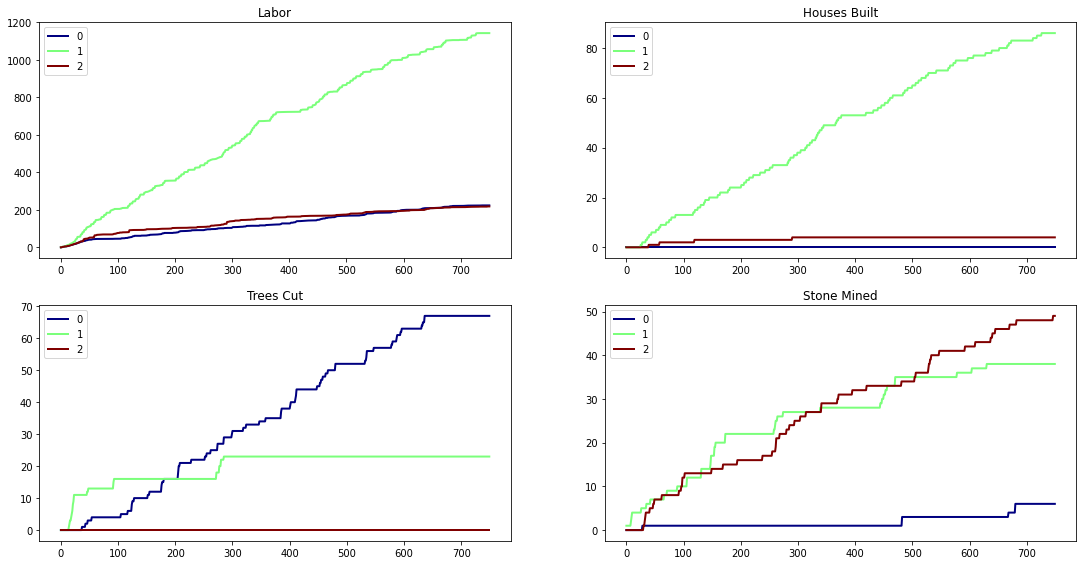

In [45]:
# print(dense_logs.keys())
# for key in dense_logs.keys():
#     with open(f'dense_log_{key}.yaml', 'w') as file:
#         yaml.dump(dense_logs[key], file, default_flow_style=False)

# plotting layout
for exp_idx, exp in enumerate(exp_names):
    exp_log = dense_log_dicts[0][exp]
    print(f"Visualizing Exp [{exp}]")

    (fig0,fig1,fig2,fig3,fig4), _, _, _, _ = plot_new.breakdown(exp_log)
    fig2.savefig(f"./plots/{exp_idx+1}-gained.png")
    fig3.savefig(f"./plots/{exp_idx+1}-paid.png")
    fig4.savefig(f"./plots/{exp_idx+1}-tax.png")
    plt.close()